In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()
import numba

In [6]:
pt = pd.read_csv('result1.csv')
pt.head()

,d_close,d_close_truth,d_open,d_open_truth,d_high,d_high_truth,d_low,d_low_truth,low_rate,low_rate_truth,high_rate,high_rate_truth,open_truth,close_truth,high_truth,low_truth,low_error,high_error
0,-3.216865,-5.470000,-3.895989,-5.420000,-1.372101,17.450001,-0.039692,-0.750000,-0.007001,-0.001364,0.007328,0.009550,4180.000023,4185.679997,4219.919999,4174.299981,-0.005637,-0.002223
1,-3.081244,-7.840000,1.254893,10.530000,0.290727,-11.120000,-3.897600,-3.780000,-0.006873,-0.004775,0.007170,0.004360,4190.530009,4177.840028,4208.799990,4170.520018,-0.002098,0.002810
2,-3.426690,39.119998,-0.725347,-7.960000,-1.648238,13.989999,-3.540981,-15.349999,-0.007261,-0.006551,0.007263,0.009616,4182.569973,4216.960029,4222.790031,4155.170000,-0.000710,-0.002353
3,-5.165221,-36.860000,1.195092,23.220001,0.616437,-10.880000,-4.070754,18.370001,-0.007391,-0.007668,0.006980,0.001455,4205.789971,4180.100030,4211.910013,4173.540015,0.000277,0.005525
4,-2.830281,-29.030001,-2.223986,-31.239999,-1.439715,-26.250001,-3.570105,-22.469999,-0.007611,-0.005625,0.007329,0.002661,4174.550017,4151.070027,4185.660009,4151.069995,-0.001987,0.004668


In [7]:
def selc_func(x):
    #return np.log(x + 1)
    return 1
def wy_tradegy(predmax, predmin, truemax, truemin, trueopen, trueover, setwater = 0.5):
    open_money = trueopen * (1 - setwater)
    ticket = setwater
    res = open_money
    mid = trueopen
    if truemin < mid:
        theory_ke = int((mid - predmin) / 0.01)
        real_ke = int((mid - truemin) / 0.01)
        ssum = 0.0
        for i in range(theory_ke):
            ssum += selc_func(i)
        
        for i in range(min(real_ke, theory_ke)):
            res -= ((mid - i * 0.01) * selc_func(i) / ssum) * setwater
            ticket += (selc_func(i) / ssum) * setwater
    if truemax > mid:
        theory_ke = int((predmax - mid) / 0.01)
        real_ke = int((truemax - mid) / 0.01)
        ssum = 0.0
        for i in range(theory_ke):
            ssum += selc_func(i)
        
        for i in range(min(real_ke, theory_ke)):
            res += ((mid + i * 0.01) * selc_func(i) / ssum) * setwater
            ticket -= (selc_func(i) / ssum) * setwater
    res += trueover*(ticket - setwater)
    ticket = setwater
    return res/trueover + setwater
 

In [99]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [100]:
class Agent:

    def __init__(self, model, window_size, trend,test_trend, skip, initial_money,POPULATION_SIZE=20,SIGMA=0.1,LEARNING_RATE=0.03, htrend = None,ltrend = None, htrue = None,ltrue = None):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 
        self.trend = trend
        self.htrend = htrend
        self.htrue = htrue
        self.ltrue = ltrue
        self.ltrend = ltrend
        self.test_trend = test_trend
        self.skip = skip
        self.initial_money = initial_money
        self.POPULATION_SIZE = POPULATION_SIZE
        self.SIGMA = SIGMA
        self.LEARNING_RATE = LEARNING_RATE
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_test_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.test_trend[d : t + 1] if d >= 0 else -d * [self.test_trend[0]] + self.test_trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])


    def get_reward(self, weights):
        res = 1.0
        for i in range(len(self.trend) - 1):
            res+=wy_tradegy(self.htrend[i]*self.trend[i], self.ltrend[i]*self.trend[i], self.htrue[i], self.ltrue[i],)
        """
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100
        # states_buy, states_sell, total_gains, invest = self.buy()
        # return invest
        """

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_test_state(45)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        
        for t in range(0, len(self.test_trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_test_state(t + 1)
            
            if action == 1 and initial_money >= self.test_trend[t]:
                inventory.append(self.test_trend[t])
                initial_money -= (self.test_trend[t] + 1)
                states_buy.append(t)
                #print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.test_trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += (self.test_trend[t]-1)
                states_sell.append(t)
                try:
                    invest = ((test[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                #print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'% (t, close[t], invest, initial_money))
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [101]:
close = pt.close_truth.values.tolist()
window_size = 200
skip = 1
initial_money = 10000
test = close[-600:]
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close[:-600],
              skip = skip,
              test_trend=close[-600:],
              initial_money = initial_money,
              LEARNING_RATE=0.03,
              htrend=pt.high_rate.values.tolist()[-600:],
              ltrend=pt.low_rate.values.tolist()[-600:]
)
agent.fit(iterations = 300, checkpoint = 10)

iter 10. reward: -4.973967
iter 20. reward: 20.722315
iter 30. reward: 30.013869
iter 40. reward: 35.963704
iter 50. reward: 35.431055
iter 60. reward: 74.310832
iter 70. reward: 79.776662
iter 80. reward: 82.430246
iter 90. reward: 85.577967
iter 100. reward: 86.249530
iter 110. reward: 89.980585
iter 120. reward: 91.828199
iter 130. reward: 97.755635
iter 140. reward: 94.095791
iter 150. reward: 97.467279
iter 160. reward: 98.017224
iter 170. reward: 99.726045
iter 180. reward: 98.165490
iter 190. reward: 97.755731
iter 200. reward: 101.446576
iter 210. reward: 99.686070
iter 220. reward: 99.947915
iter 230. reward: 96.641450
iter 240. reward: 100.193527
iter 250. reward: 96.263685
iter 260. reward: 99.715865
iter 270. reward: 99.341871
iter 280. reward: 101.275640
iter 290. reward: 102.614953
iter 300. reward: 103.597787
time taken to train: 113.2925922870636 seconds


In [102]:
agent.fit(iterations = 600, checkpoint = 100)

iter 100. reward: 112.895474
iter 200. reward: 114.757817
iter 300. reward: 115.190358
iter 400. reward: 117.671202
iter 500. reward: 119.266722
iter 600. reward: 120.284703
time taken to train: 223.2092592716217 seconds


In [103]:
states_buy, states_sell, total_gains, invest = agent.buy()

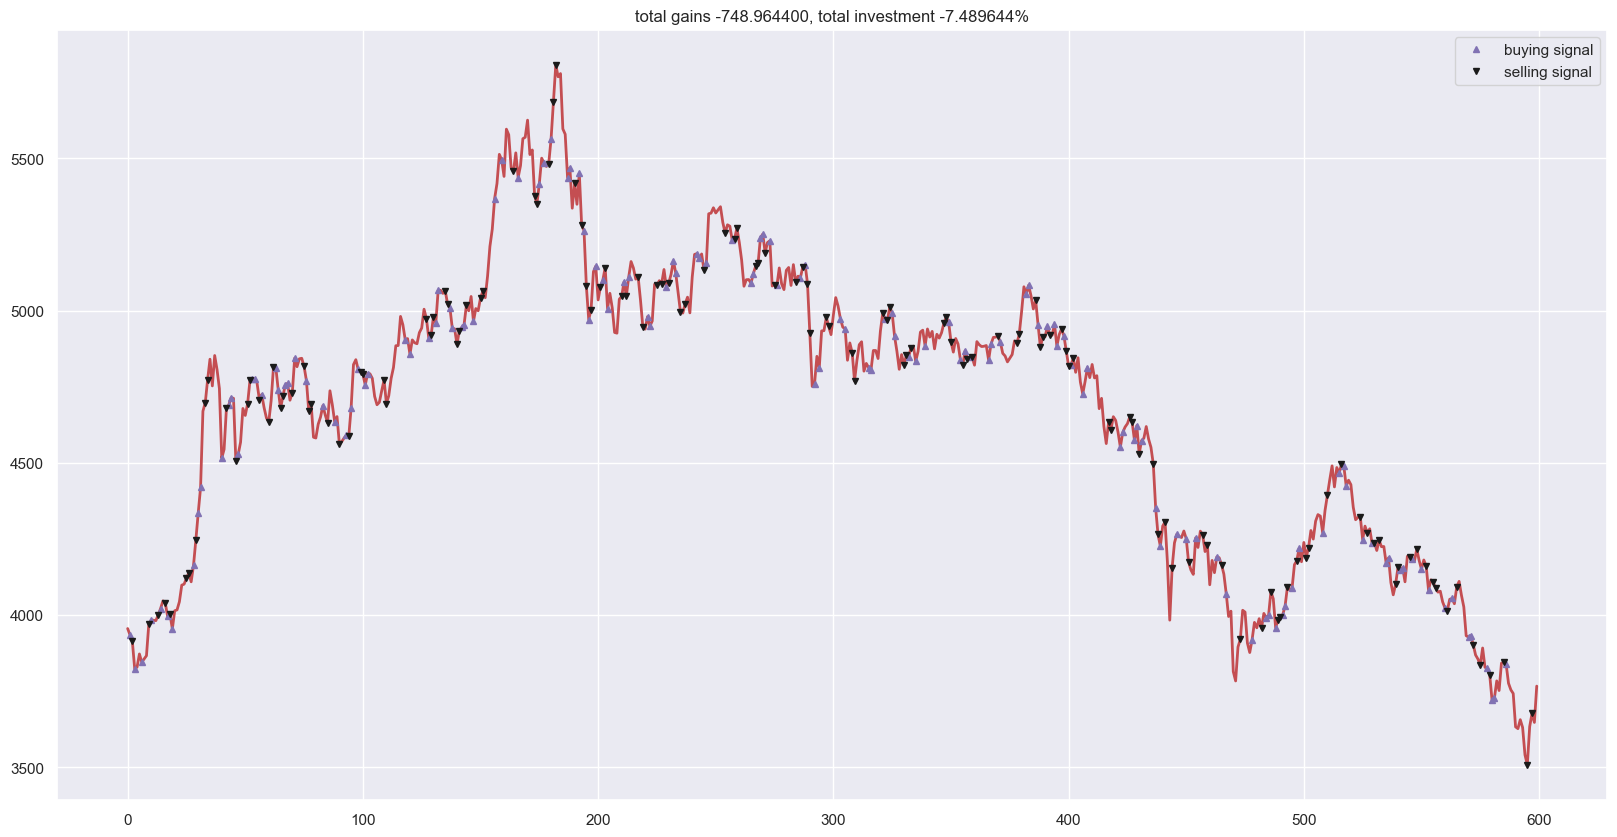

In [105]:
fig = plt.figure(figsize = (20,10))
plt.plot(close[-600:], color='r', lw=2.)
plt.plot(close[-600:], '^', markersize=5, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close[-600:], 'v', markersize=5, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()